# Import Relevant Libraries 

In [476]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import datasets


# Read LiverEnzymes DataSet and Import

In [477]:
dfLiverEnz = pd.read_csv('C:/Users/Arin.DESKTOP-T794926/Downloads/liver_patient.csv')
dfLiverEnz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null object
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    579 non-null float64
Dataset                       583 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


# Rename Columns and Add a AST/ALT Ratio Column

In [478]:
dfLiverEnz.rename(columns={'Alkaline_Phosphotase': 'ALP'}, inplace=True)
dfLiverEnz.rename(columns={'Alamine_Aminotransferase': 'ALT'}, inplace=True)
dfLiverEnz.rename(columns={'Aspartate_Aminotransferase': 'AST'}, inplace=True)
dfLiverEnz.rename(columns={'Total_Protiens': 'TP'}, inplace=True)
dfLiverEnz.rename(columns={'Albumin_and_Globulin_Ratio': 'A/G'}, inplace=True)
dfLiverEnz['ALT/AST'] = dfLiverEnz['ALT']/dfLiverEnz['AST']
dfLiverEnz
dfLiverEnz = dfLiverEnz[['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin','ALP','ALT','AST','ALT/AST','TP','Albumin','A/G']]


## Set Diagnosis Lab Markers
#### Cirhosis: Total Bilirubin > 2
#### ALD: ALT/AST > .5
#### Fatty Liver: ALT  > 50 
#### Hepatitis C: ALT > 200

In [479]:
dfLiverEnz['Diagnosis:Cirhosis'] = np.where(dfLiverEnz['Total_Bilirubin']>2, 1,0)
dfLiverEnz['Diagnosis:ALD'] = np.where(dfLiverEnz['ALT/AST']>.5, 1,0)
dfLiverEnz['Diagnosis:Fatty Liver'] = np.where(dfLiverEnz['ALT']>50, 1,0)
dfLiverEnz['Diagnosis:Hepatitis C'] = np.where(dfLiverEnz['ALT']>200, 1,0)

# We will focus on Cirhosis
#### As you can see from the data there are more patients who have a negative risk for cirhosis vs positive

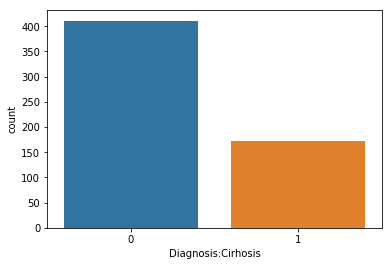

In [480]:
sns.countplot (x='Diagnosis:Cirhosis', data = dfLiverEnz)


### Stripplot Demonstrating the differences in the amount of male and female data and the amount of patients at risk of cirhosis vs not at risk. 

C:\Users\Arin.DESKTOP-T794926\Anaconda3\lib\site-packages\seaborn\categorical.py:2567: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


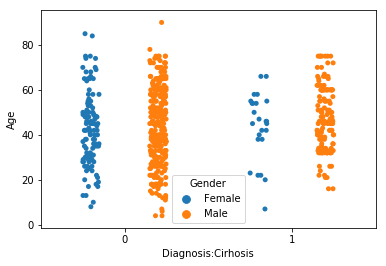

In [481]:

sns.stripplot(x='Diagnosis:Cirhosis', y = 'Age', data = dfLiverEnz, hue = 'Gender',jitter = True,split= True)


#### Facet Grids Show us ALT levels in male vs female patients in patients who have risk of cirhosis and patients who don't have risk. Patients who do have a risk of cirhosis tend to have Total_Bilirubin levels that are more sporadic.

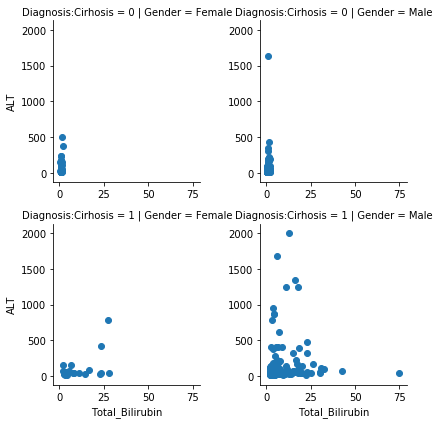

In [482]:
g = sns.FacetGrid(data = dfLiverEnz, col = 'Gender', row = 'Diagnosis:Cirhosis')
g.map(plt.scatter,'Total_Bilirubin','ALT')

#### We will clean up our data to hold only numerical values which will make it easier for our logistic regression algorithim to analyze the dataset. 

# Logistic Regression Model
#### Now that we have dropped the appropriate columns we can train our model. Lets trying to predict a diagnosis of cirhosis based on Total_Bilirubin

In [483]:
Gender = pd.get_dummies(dfLiverEnz['Gender'],drop_first = True)
dfLiverEnz = pd.concat([dfLiverEnz,Gender],axis = 1)
#dfLiverEnz.drop(['Gender','Diagnosis:ALD','Diagnosis:Fatty Liver', 'Diagnosis:Hepatitis C','Age','Direct_Bilirubin', 'ALP', 'ALT','AST', 'ALT/AST','TP',Albumin', 'A/G','Male'],axis =1, inplace = True)
dfLiverEnz.drop(['Gender','Diagnosis:ALD','Diagnosis:Fatty Liver', 'Diagnosis:Hepatitis C','A/G','Male'],axis =1, inplace = True)

In [484]:
X = dfLiverEnz.drop('Diagnosis:Cirhosis',axis = 1)
y = dfLiverEnz['Diagnosis:Cirhosis']
dfLiverEnz = dfLiverEnz.dropna(axis=1, how='any')

In [485]:
from sklearn.cross_validation import train_test_split

In [486]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [487]:
from sklearn.linear_model import LogisticRegression

#### Now that our data has been trained we can use logistic regression to try and make our predictions

In [488]:
logmodel = LogisticRegression()

In [489]:
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [490]:
predictions = logmodel.predict(X_test)

In [491]:
from sklearn.metrics import classification_report

## Results
##### Our Precision is tp / (tp+fp) Where tp is true positive and fp is false positive 
#### The precision is the abilty of the classifer not to label as postive a sample that is negative. 
#### The Recall is tp /(tp+fn) where fn is false negative 
#### The recall is the ability of the classifer to find all positive values
#### The harmonic mean of the precision and recall is the F1-support the closer to 1 means a better score. 

In [492]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99       149
          1       0.93      0.98      0.96        44

avg / total       0.98      0.98      0.98       193



In [493]:
from sklearn.metrics import confusion_matrix

#### A Confusion Matrix shows us how often the data was accurately predicted. As you can see in 146 instances the data was correctly predicted to be positive
#### In 43 instances the data was predicted to be negative
#### In 3 instances the data was predicated to be positive but was actually negative
#### In 1 instance the data was predicated to negative but was actually positive


In [494]:
confusion_matrix(y_test,predictions)

array([[146,   3],
       [  1,  43]], dtype=int64)

# Trees and Random Forests
### 1st step is to train a tree

In [495]:
from sklearn.cross_validation import train_test_split

In [496]:
X = dfLiverEnz.drop('Diagnosis:Cirhosis',axis=1)
y = dfLiverEnz['Diagnosis:Cirhosis']

In [497]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [498]:
from sklearn.tree import DecisionTreeClassifier

In [499]:
dtree = DecisionTreeClassifier()

In [500]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [501]:
predictions = dtree.predict(X_test)

In [502]:
from sklearn.metrics import classification_report,confusion_matrix

In [503]:
print(confusion_matrix(y_test,predictions))

[[149   0]
 [  0  44]]


In [504]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       149
          1       1.00      1.00      1.00        44

avg / total       1.00      1.00      1.00       193



#### Now Lets Run a Random Forest Classifer to see if our prediction values will change 

In [519]:
from sklearn.ensemble import RandomForestClassifier

In [521]:
rfc = RandomForestClassifier(n_estimators = 200)

In [522]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [523]:
rfc_pred = rfc.predict(X_test)

In [525]:
print(confusion_matrix(y_test,rfc_pred))

[[149   0]
 [  0  44]]


In [526]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       149
          1       1.00      1.00      1.00        44

avg / total       1.00      1.00      1.00       193

